-------------------------
# Convolution Neural Networks - Level 2 (More Sophisticated Images)
-------------------------

In [3]:
#!pip install pillow
#sys.modules['Image'] = Image 
#!pip install scipy
#!pip install matplotlib


In [4]:
# Imports
# -------
import sys
import zipfile
import scipy
import tensorflow as tf, numpy as np, pandas as pd, os, random
from PIL import Image
from os import listdir
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
print("Num GPUs Available:        ",len(tf.config.list_physical_devices('GPU')))

import matplotlib.image as mpimg, matplotlib.pyplot as plt
%matplotlib inline

Num GPUs Available:         1


We will be building a model to classify real images of cats and dogs. Like the horses and humans dataset, real-world images also come in different shapes, aspect ratios, etc. and you will need to take this into account when preparing your data.

In this lab, we will first review how to build CNNs, prepare your data with `ImageDataGenerator` and examine your results. 

We follow these steps:

1.   Explore the example data of `Dogs vs. Cats`
2.   Build and train a neural network to classify between the two pets
3.   Evaluate the training and validation accuracy

We will build upon your results here in the next labs so you can improve it, particularly in avoiding overfitting. Let's begin!

### Downloading the Data

We will start by downloading the dataset. This is a `.zip` of 2,000 JPG pictures of cats and dogs. 

It is a subset of the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. 

We will only use 2,000 of the full dataset to decrease training time for educational purposes.

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# # Unzip the archive
# # -----------------
# local_zip = '/content/drive/MyDrive/[Study]/$ Primary Study work/Python - ipynb Notebooks/Notebooks - Tensorflow for Neural Networks (Coursera)/cats_and_dogs_filtered.zip'
local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

-------------------------

The contents of the .zip are extracted to the base directory `./cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (you can ignore `vectorize.py` in the output in the next cell). 

If you recall, the **training set** is the data that is used to tell the neural network model that 'this is what a cat looks like' and 'this is what a dog looks like'. The **validation set** is images of cats and dogs that the neural network will not see as part of the training. You can use this to test how well or how badly it does in evaluating if an image contains a cat or a dog. (See the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) if you want a refresher on training, validation, and test sets.)

These subdirectories in turn each contain `cats` and `dogs` subdirectories.

-------------------------

In [8]:
# base_dir = '/content/drive/MyDrive/[Study]/$ Primary Study work/Python - ipynb Notebooks/Notebooks - Tensorflow for Neural Networks (Coursera)/cats_and_dogs_filtered'
base_dir = "cats_and_dogs_filtered"
print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['train', 'validation', 'vectorize.py']

Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


In [9]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [10]:
# Now see what the filenames look like in the cats and dogs train directories 
# (file naming conventions are the same in the validation directory):
#
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print()
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']

['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [11]:
# Let's find out the total number of cat and dog images in the train and validation directories:
#
print('total training cat images   :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images   :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images   : 1000
total training dog images   : 1000
total validation cat images : 500
total validation dog images : 500


-----------------------
For both cats and dogs, you have 1,000 training images and 500 validation images.

Now take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplotlib parameters:

-----------------------

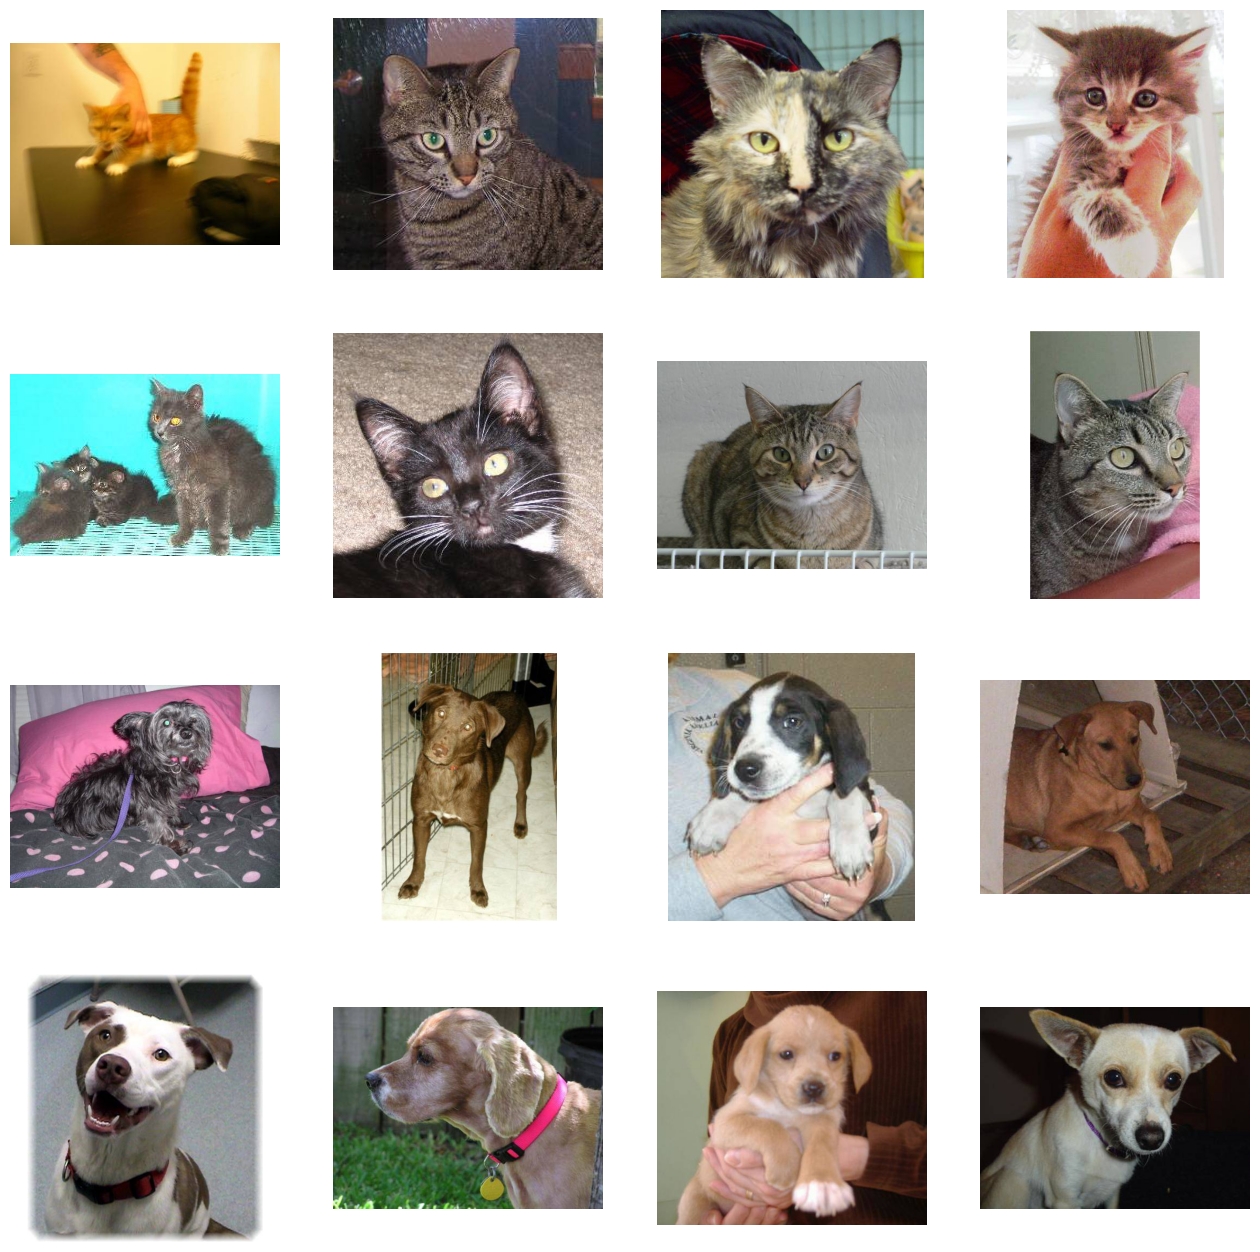

In [12]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0 # Index for iterating over images

## Now, display a batch of 8 cat and 8 dog pictures. 
## We can re-run the cell to see a fresh batch each time:
## ======================================================
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


--------------------------------
It may not be obvious from looking at the images in this grid but an important note here is that these images come in all shapes and sizes (just like the 'horses or humans' dataset). 

So before training a neural network with them, we need to tweak the images.

--------------------------------

--------------------------------------
### Starting from a Small Model

To train a neural network to handle the images, we need them to be in a uniform size. 

Let's choose 150x150 pixels for this, and then will code to preprocesses the images to that shape shortly. 

--------------------------------------

In [13]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
        # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

-------------------------------

We defined a `Sequential` layer as before, adding some convolutional layers first. 

**`Note:`** The `input_shape` parameter this time. Here is where we put the `150x150` size and `3` for the color depth because we have colored images. We then add a couple of convolutional layers and flatten the final result to feed into the densely connected layers.

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end the network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). The output of the network will be a single scalar between `0` and `1`, encoding the probability that the current image is class `1` (as opposed to class `0`).


The `output_shape` column shows how the size of your feature map evolves in each successive layer. The convolution operation removes the outermost pixels from the original dimensions, and each pooling layer halves it.


Next, we will configure the specifications for model training. 

We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

-------------------------------

In [14]:
# Compiling the Model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

------------------------
### `Data Preprocessing`

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. 

We will have one generator for the training images and one for the validation images. These generators will yield batches of images of size 150x150 and their labels (binary).

The data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) 

In this case, we will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

------------------------

In [15]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


--------------------
### `Training`

You will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses. 

--------------------

In [16]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
100/100 - 12s - loss: 0.7778 - accuracy: 0.5665 - val_loss: 0.6629 - val_accuracy: 0.6600 - 12s/epoch - 119ms/step
Epoch 2/15
100/100 - 6s - loss: 0.6401 - accuracy: 0.6540 - val_loss: 0.6570 - val_accuracy: 0.6030 - 6s/epoch - 63ms/step
Epoch 3/15
100/100 - 6s - loss: 0.5695 - accuracy: 0.7210 - val_loss: 0.6444 - val_accuracy: 0.6830 - 6s/epoch - 62ms/step
Epoch 4/15
100/100 - 7s - loss: 0.4871 - accuracy: 0.7755 - val_loss: 0.6413 - val_accuracy: 0.6710 - 7s/epoch - 66ms/step
Epoch 5/15
100/100 - 6s - loss: 0.3613 - accuracy: 0.8405 - val_loss: 0.7645 - val_accuracy: 0.6510 - 6s/epoch - 63ms/step
Epoch 6/15
100/100 - 6s - loss: 0.2773 - accuracy: 0.8870 - val_loss: 0.8792 - val_accuracy: 0.6380 - 6s/epoch - 64ms/step
Epoch 7/15
100/100 - 7s - loss: 0.2089 - accuracy: 0.9135 - val_loss: 0.7657 - val_accuracy: 0.6960 - 7s/epoch - 65ms/step
Epoch 8/15
100/100 - 6s - loss: 0.1373 - accuracy: 0.9500 - val_loss: 1.0920 - val_accuracy: 0.6710 - 6s/epoch - 63ms/step
Epoch 9/15
10

--------------------
### `Predicting on Unseen Images`

1/1 [==============================] - 0s 22ms/step


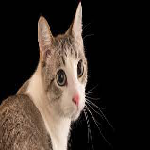

Image is a cat
1/1 [==============================] - 0s 22ms/step


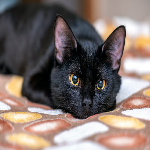

Image is a dog
1/1 [==============================] - 0s 21ms/step


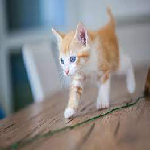

Image is a cat
1/1 [==============================] - 0s 21ms/step


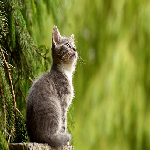

Image is a cat
1/1 [==============================] - 0s 21ms/step


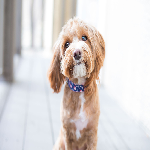

Image is a dog
1/1 [==============================] - 0s 21ms/step


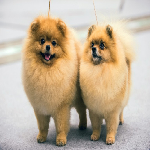

Image is a dog
1/1 [==============================] - 0s 22ms/step


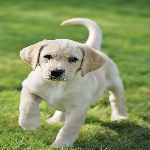

Image is a dog
1/1 [==============================] - 0s 21ms/step


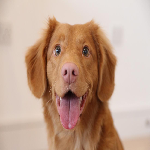

Image is a dog
1/1 [==============================] - 0s 21ms/step


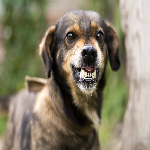

Image is a dog


In [32]:
# Predicting images
# -----------------
# get the path/directory
#folder_dir = r"G:\My Drive\[Study]\$ Primary Study work\Python - ipynb Notebooks\Data\Dataset 2 - Dogs vs Cats\Testing Images"

folder_dir = r"./Testing Images/"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")): # Check if image is a .jpg
        
        
        path = folder_dir + '\\' + images
        
        
        img = load_img(path, target_size=(150, 150))

        x = img_to_array(img)
        x /= 255
       
        x=np.expand_dims(x, axis=0)
        images = np.vstack([x])

        classes = model.predict(images, batch_size=10)
        #print(classes[0])
        
        display(img)
        if classes[0]>0.5:
            print("Image is a dog")
        else:
            print("Image is a cat")




-------------------

### `Visualizing Intermediate Representations`

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

-------------------

1/1 [==============================] - 0s 204ms/step


C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


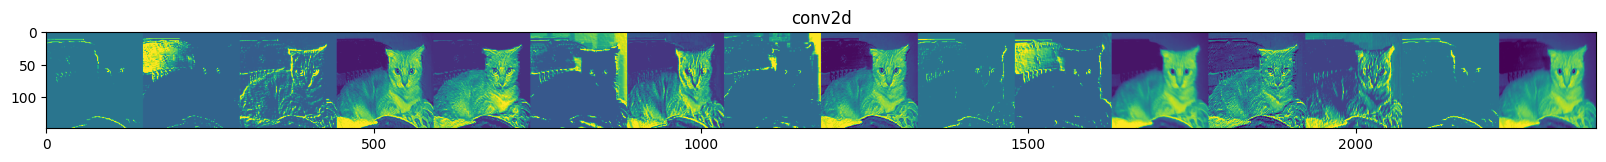

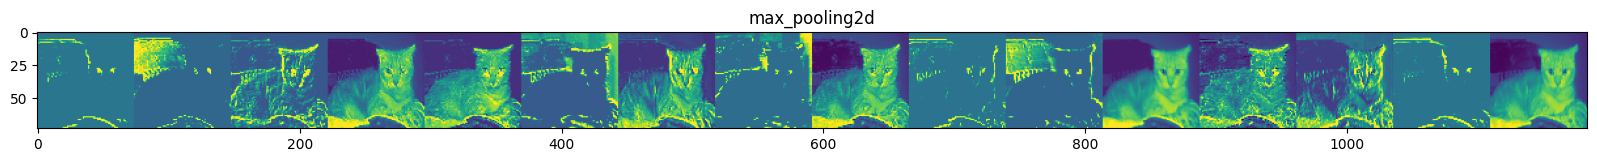

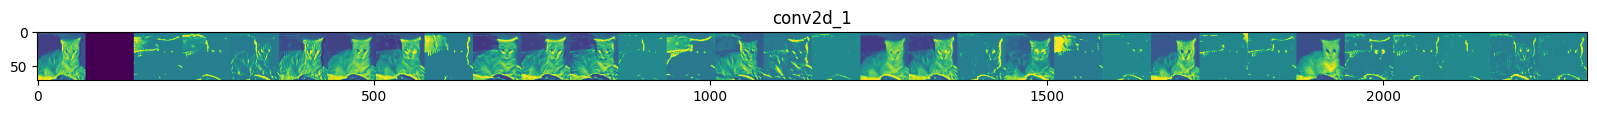

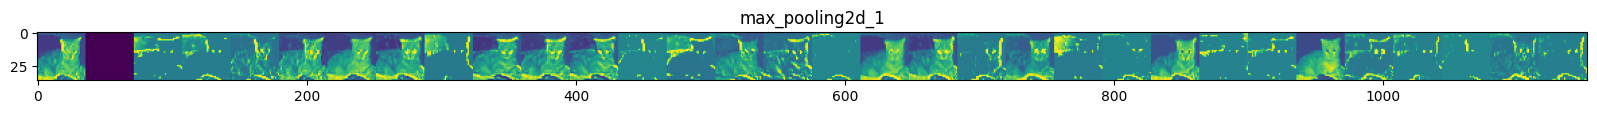

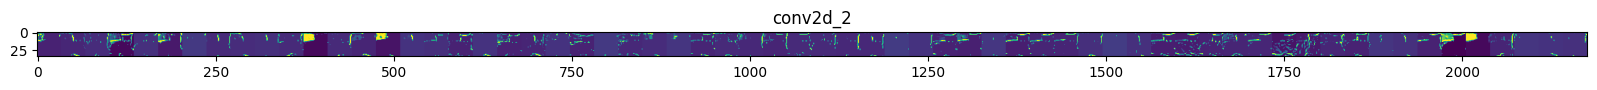

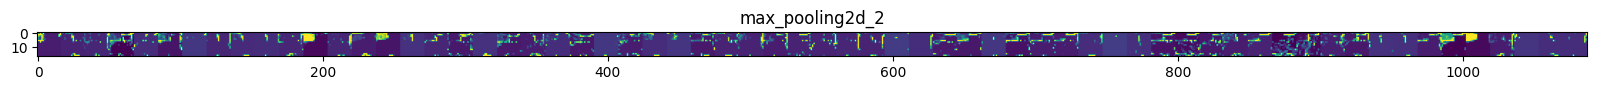

In [23]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

---------------------------------
You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid. 

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

---------------------------------

### `Evaluating Accuracy and Loss for the Model`

You will plot the training/validation accuracy and loss as collected during training:

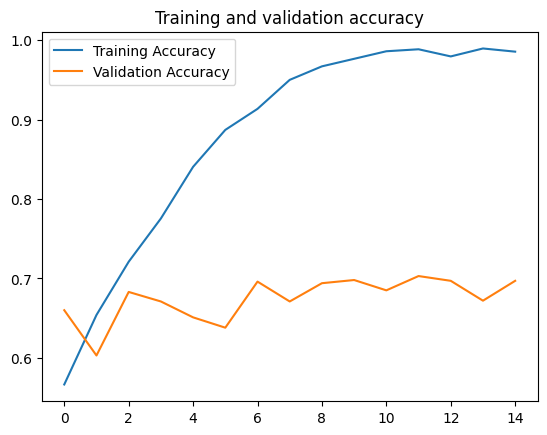

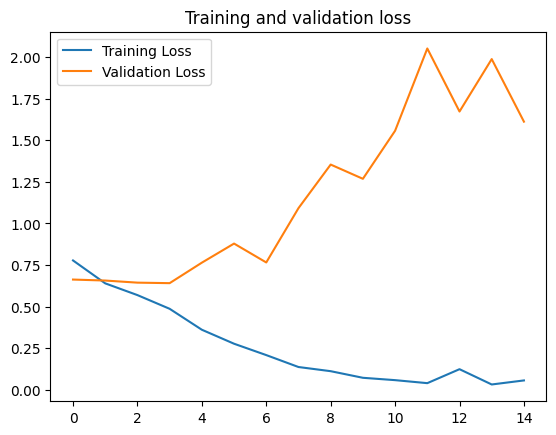

In [24]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc , label = "Training Accuracy")
plt.plot  ( epochs, val_acc , label = "Validation Accuracy")
plt.title ('Training and validation accuracy')
plt.legend(loc="upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , label = "Training Loss")
plt.plot  ( epochs, val_loss , label = "Validation Loss")
plt.title ('Training and validation loss'   )
plt.legend(loc="upper left")

------------------------
As you can see, the model is **overfitting** like it's getting out of fashion. The training accuracy (in blue) gets close to 100% while the validation accuracy (in orange) stalls as 70%. The validation loss reaches its minimum after only five epochs.

Since you have a relatively small number of training examples (2000), overfitting should be the number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that you are fitting the parameters of our model to a given dataset, how can you make sure that the representations learned by the model will be applicable to data it has never seen before? How do you avoid learning things that are specific to the training data?

In the next exercise, you'll look at ways to prevent overfitting in this classification model.

------------------------

-------------------

## Image Augmentation

-------------------


You'll be looking a lot at Image Augmentation this week. 

Image Augmentation is a very simple, but very powerful tool to help you avoid overfitting your data. The concept is very simple though: If you have limited data, then the chances of you having data to match potential future predictions is also limited, and logically, the less data you have, the less chance you have of getting accurate predictions for data that your model hasn't yet seen. To put it simply, if you are training a model to spot cats, and your model has never seen what a cat looks like when lying down, it might not recognize that in future.

Augmentation simply amends your images on-the-fly while training using transforms like rotation. So, it could 'simulate' an image of a cat lying down by rotating a 'standing' cat by 90 degrees. As such you get a cheap way of extending your dataset beyond what you have already. 

To learn more about Augmentation, and the available transforms, check out https://keras.io/api/layers/preprocessing_layers/ -- and note that it's referred to as preprocessing for a very powerful reason: that it doesn't require you to edit your raw images, nor does it amend them for you on-disk. It does it in-memory as it's performing the training, allowing you to experiment without impacting your dataset. 



### Using `Image Data Generator` for Image Augmentation

------------------

#### <font color='magenta'> BEFORE AUGMENTATION </font>

In [51]:
## Function for Plotting Loss and Accuracy
# ----------------------------------------

def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.figure(figsize=(13,3))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy', color='red')
    plt.title('Training and validation accuracy')

    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss', color='red')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


In [54]:
# Function for Creating the model 

def create_model():
  '''Creates a CNN with 4 convolutional layers'''
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model


# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


# Constant for epochs
EPOCHS = 20

# Create a new model
model = create_model()

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 - 8s - loss: 0.6900 - accuracy: 0.5395 - val_loss: 0.6745 - val_accuracy: 0.6470 - 8s/epoch - 78ms/step
Epoch 2/20
100/100 - 7s - loss: 0.6520 - accuracy: 0.6145 - val_loss: 0.6533 - val_accuracy: 0.6040 - 7s/epoch - 66ms/step
Epoch 3/20
100/100 - 7s - loss: 0.6009 - accuracy: 0.6690 - val_loss: 0.6037 - val_accuracy: 0.6840 - 7s/epoch - 66ms/step
Epoch 4/20
100/100 - 7s - loss: 0.5728 - accuracy: 0.6995 - val_loss: 0.5982 - val_accuracy: 0.6890 - 7s/epoch - 67ms/step
Epoch 5/20
100/100 - 7s - loss: 0.5431 - accuracy: 0.7210 - val_loss: 0.5667 - val_accuracy: 0.7010 - 7s/epoch - 67ms/step
Epoch 6/20
100/100 - 6s - loss: 0.5151 - accuracy: 0.7525 - val_loss: 0.5696 - val_accuracy: 0.7030 - 6s/epoch - 64ms/step
Epoch 7/20
100/100 - 7s - loss: 0.4911 - accuracy: 0.7690 - val_loss: 0.6408 - val_accuracy: 0.6540 - 7s/epoch - 67ms/step
Epoch 8/20
100/100 - 7s - loss: 0.4616 - accuracy: 0.77

C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


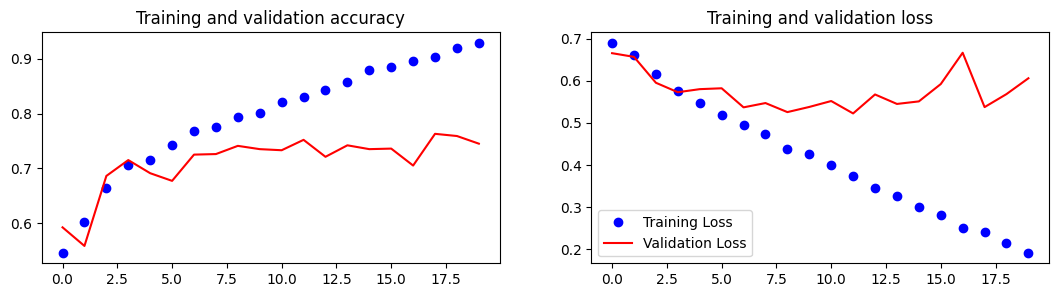

In [50]:
# Plot training results
plot_loss_acc(history)

From the results above, you’ll see the training accuracy is more than 90%, and the validation accuracy is in the 70%-80% range. This is a great example of overfitting – which in short means that it can do very well with images it has seen before, but not so well with images it hasn’t.

In [ ]:
### After Augmentation


In [52]:
# Create new model
model_for_aug = create_model()

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Train the new model
history_with_aug = model_for_aug.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 - 15s - loss: 0.6913 - accuracy: 0.5355 - val_loss: 0.6764 - val_accuracy: 0.5360 - 15s/epoch - 151ms/step
Epoch 2/20
100/100 - 14s - loss: 0.6776 - accuracy: 0.5720 - val_loss: 0.6516 - val_accuracy: 0.6050 - 14s/epoch - 142ms/step
Epoch 3/20
100/100 - 14s - loss: 0.6677 - accuracy: 0.5855 - val_loss: 0.6349 - val_accuracy: 0.6280 - 14s/epoch - 137ms/step
Epoch 4/20
100/100 - 14s - loss: 0.6535 - accuracy: 0.6045 - val_loss: 0.6158 - val_accuracy: 0.6590 - 14s/epoch - 139ms/step
Epoch 5/20
100/100 - 14s - loss: 0.6334 - accuracy: 0.6320 - val_loss: 0.5963 - val_accuracy: 0.6790 - 14s/epoch - 137ms/step
Epoch 6/20
100/100 - 14s - loss: 0.6162 - accuracy: 0.6570 - val_loss: 0.5730 - val_accuracy: 0.7010 - 14s/epoch - 137ms/step
Epoch 7/20
100/100 - 14s - loss: 0.6121 - accuracy: 0.6580 - val_loss: 0.5907 - val_accuracy: 0.6590 - 14s/epoch - 139ms/step
Epoch 8/20
100/100 - 14s - loss: 0

C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  
C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


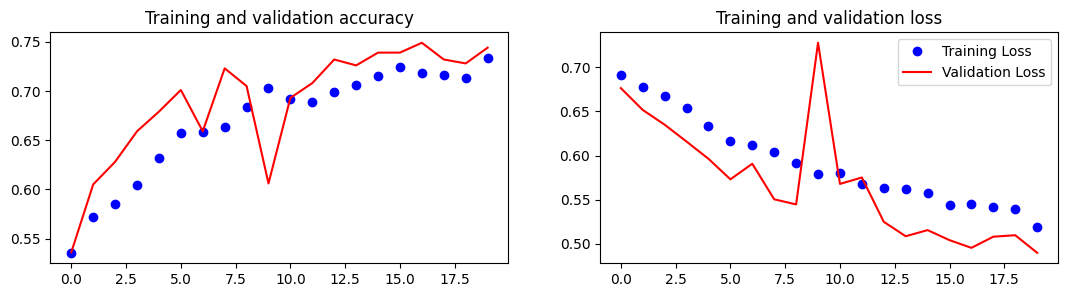

In [53]:
# Plot training results
plot_loss_acc(history_with_aug)

As you can see, the training accuracy has gone down compared to the baseline. This is expected because (as a result of data augmentation) there are more variety in the images so the model will need more runs to learn from them. The good thing is the validation accuracy is no longer stalling and is more in line with the training results. This means that the model is now performing better on unseen data. 

--------------------
#### `Predicting on Unseen Images`

--------------------

1/1 [==============================] - 0s 235ms/step


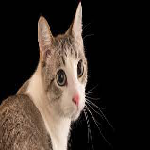

Image is a cat
1/1 [==============================] - 0s 23ms/step


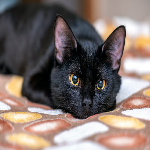

Image is a cat
1/1 [==============================] - 0s 27ms/step


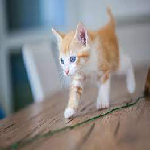

Image is a cat
1/1 [==============================] - 0s 23ms/step


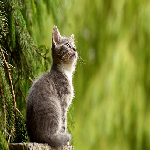

Image is a dog
1/1 [==============================] - 0s 22ms/step


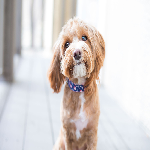

Image is a dog
1/1 [==============================] - 0s 21ms/step


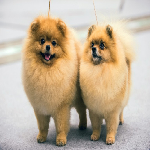

Image is a dog
1/1 [==============================] - 0s 22ms/step


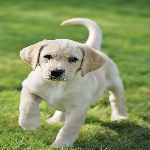

Image is a dog
1/1 [==============================] - 0s 23ms/step


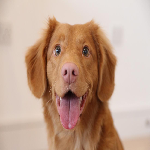

Image is a dog
1/1 [==============================] - 0s 29ms/step


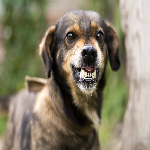

Image is a dog


In [55]:
# Predicting images
# -----------------
# get the path/directory
#folder_dir = r"G:\My Drive\[Study]\$ Primary Study work\Python - ipynb Notebooks\Data\Dataset 2 - Dogs vs Cats\Testing Images"

folder_dir = r"./Testing Images/"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")): # Check if image is a .jpg
        
        
        path = folder_dir + '\\' + images
        
        
        img = load_img(path, target_size=(150, 150))

        x = img_to_array(img)
        x /= 255
       
        x=np.expand_dims(x, axis=0)
        images = np.vstack([x])

        classes = model_for_aug.predict(images, batch_size=10)
        #print(classes[0])
        
        display(img)
        if classes[0]>0.5:
            print("Image is a dog")
        else:
            print("Image is a cat")